In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from scipy.stats import ks_2samp

In [2]:
acctDF = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
acctDF['balance_date'] = pd.to_datetime(acctDF['balance_date'])

consDF_all = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')

consDF = consDF_all.dropna()
trxnDF = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')
trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

cat_map = pd.read_csv('../../data/q2-ucsd-cat-map.csv')


In [3]:
cat_map.category.unique()

array(['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'DEPOSIT', 'PAYCHECK',
       'MISCELLANEOUS', 'PAYCHECK_PLACEHOLDER', 'REFUND',
       'INVESTMENT_INCOME', 'OTHER_BENEFITS', 'UNEMPLOYMENT_BENEFITS',
       'SMALL_DOLLAR_ADVANCE', 'TAX', 'LOAN', 'INSURANCE',
       'FOOD_AND_BEVERAGES', 'UNCATEGORIZED', 'GENERAL_MERCHANDISE',
       'AUTOMOTIVE', 'GROCERIES', 'ATM_CASH', 'ENTERTAINMENT', 'TRAVEL',
       'ESSENTIAL_SERVICES', 'ACCOUNT_FEES', 'HOME_IMPROVEMENT',
       'OVERDRAFT', 'CREDIT_CARD_PAYMENT', 'HEALTHCARE_MEDICAL', 'PETS',
       'EDUCATION', 'GIFTS_DONATIONS', 'BILLS_UTILITIES', 'MORTGAGE',
       'CHILD_DEPENDENTS', 'RENT', 'BNPL', 'AUTO_LOAN',
       'BANKING_CATCH_ALL', 'DEBT', 'FITNESS', 'TRANSPORATION', 'LEGAL',
       'GOVERNMENT_SERVICES', 'RISK_CATCH_ALL', 'RTO_LTO', 'INVESTMENT',
       'GAMBLING', 'CORPORATE_PAYMENTS', 'TIME_OR_STUFF', 'PENSION'],
      dtype=object)

In [4]:
display(acctDF), display(consDF), display(trxnDF)

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.7500
24462,11615,24462,SAVINGS,2022-03-30,5.0000
24463,11615,24463,CHECKING,2022-03-30,"1,956.4600"
24464,12210,24464,CHECKING,2022-03-28,"2,701.5100"


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0000,0.0000
1,1,2021-07-01,626.0000,0.0000
2,2,2021-05-01,680.0000,0.0000
3,3,2021-03-01,734.0000,0.0000
4,4,2021-10-01,676.0000,0.0000
...,...,...,...,...
13995,13995,2022-01-22,802.0000,0.0000
13996,13996,2022-02-01,652.0000,0.0000
13997,13997,2021-12-24,765.0000,0.0000
13998,13998,2022-01-30,685.0000,0.0000


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.9600,DEBIT,2022-03-11
6407317,10533,6405305,12,63.4800,DEBIT,2022-03-30
6407318,10533,6405306,12,53.9900,DEBIT,2022-03-30
6407319,10533,6405307,12,175.9800,DEBIT,2022-03-31


(None, None, None)

In [5]:
acctConsDF = consDF.merge(acctDF, how='left', on='prism_consumer_id',)
acctConsDF.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance
0,0,2021-09-01,726.0000,0.0000,862,SAVINGS,2021-08-31,25.7000
1,0,2021-09-01,726.0000,0.0000,863,CHECKING,2021-08-31,294.6700
2,1,2021-07-01,626.0000,0.0000,7754,SAVINGS,2021-06-30,"3,211.1800"
3,1,2021-07-01,626.0000,0.0000,7755,CHECKING,2021-06-30,91.2400
4,2,2021-05-01,680.0000,0.0000,4666,SAVINGS,2021-04-30,"2,561.4300"


# Week 1 - Best Single Feature

### Test Predictability w/ Logistic Regression Model

In [6]:
def lr_best_single(X, y):
    """
    Trains a logistic regression model on the provided data, evaluates its performance, 
    and returns key metrics.

    Parameters:
    ----------
    X : array-like or DataFrame
        Feature matrix containing predictor variables.
    y : array-like or Series
        Target variable (binary classification).

    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute R^2
    # ll_model = -log_loss(y, model.predict_proba(X), normalize=False)
    # ll_null = -log_loss(y, [y.mean()] * len(y), normalize=False)
    # r2 = 1 - (ll_model / ll_null)

    r = np.corrcoef(y.squeeze(), X.squeeze())[0][1]
    r2 = (r) ** 2
    

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"r^2 value: {r2:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, roc_auc, confusion_matrix, classification_report(y_test, y_pred)


In [7]:
def ks_test(data, ftr='credit_score', target='DQ_TARGET'):
    """
    Performs the Kolmogorov-Smirnov (KS) test to compare the distributions 
    of two samples and returns the KS statistic and p-value.

    Parameters:
    ----------
    ftr_0 : array-like
        Sample values for the first group (e.g., feature values for class 0).
    ftr_1 : array-like
        Sample values for the second group (e.g., feature values for class 1).

    Returns:
    -------
    ks_stat : float
        The KS statistic, representing the maximum difference between the two cumulative distributions.
    p_value : float
        The p-value indicating the significance of the difference between the distributions.


    Notes:
    ------

    If the P value is small, conclude that the two groups were sampled from populations with different distributions. 
    The populations may differ in median, variability or the shape of the distribution.

    """
    
    ftr_0 = data[data[target] == 0][ftr].dropna()
    ftr_1 = data[data[target] == 1][ftr].dropna()

    if ftr_0.empty or ftr_1.empty:
        print(f"Warning: One of the groups is empty. KS test cannot be performed.")
        return np.nan, np.nan
    if ftr_0.nunique() == 1 or ftr_1.nunique() == 1:
        print(f"Warning: One of the groups has only one unique value. KS test may not be valid.")
        return np.nan, np.nan
        
    ks_stat, p_value = ks_2samp(ftr_0, ftr_1)

    print(f"KS_stat  = {ks_stat}")
    print(f"p value = {p_value}")

    # Adaptive binning using Freedman-Diaconis rule
    def get_bins(series):
        q75, q25 = np.percentile(series, [75, 25])
        bin_width = 2 * (q75 - q25) / (len(series) ** (1/3))  # Freedman-Diaconis rule
        if bin_width > 0:
            return max(10, min(50, int((series.max() - series.min()) / bin_width))) # Ensure at least 10 bins
        else:
            return 10  # Default bins if spread is too small
    
    bins_0 = get_bins(ftr_0)
    bins_1 = get_bins(ftr_1)
    bins = max(bins_0, bins_1)  # Use the larger bin count for better visualization

    print(f"Num of bins = {bins}")

    # Plot distributions
    plt.figure(figsize=(8, 6))
    plt.hist(ftr_0, bins=bins, alpha=0.5, label=f"{ftr} (DQ_TARGET=0)", density=True, edgecolor='black')
    plt.hist(ftr_1, bins=bins, alpha=0.5, label=f"{ftr} (DQ_TARGET=1)", density=True, edgecolor='black')
    plt.title(f"Distribution of {ftr} by {target}")
    plt.xlabel(ftr)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    return ks_stat, p_value

    
    return ks_stat, p_value


### Credit Score - DQ_TARGET

In [8]:
credit_scoreDF = consDF[['credit_score', 'DQ_TARGET']]
credit_scoreDF.head()

,credit_score,DQ_TARGET
0,726.0000,0.0000
1,626.0000,0.0000
2,680.0000,0.0000
3,734.0000,0.0000
4,676.0000,0.0000


In [9]:
corr_credit_score = consDF['credit_score'].corr(consDF.DQ_TARGET)
corr_credit_score

-0.2613083627746771

In [10]:
cs_X = consDF[['credit_score']]
y = consDF[['DQ_TARGET']]

accuracy, roc_auc, confusion_matrix, cr = lr_best_single(cs_X, y)

ROC AUC Score: 0.7497
Accuracy: 0.9125
r^2 value: 0.0683

Confusion Matrix:
[[2187    5]
 [ 205    3]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.38      0.01      0.03       208

    accuracy                           0.91      2400
   macro avg       0.64      0.51      0.49      2400
weighted avg       0.87      0.91      0.87      2400



/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS_stat  = 0.3881249523054506
p value = 1.4927461734165962e-125
Num of bins = 50


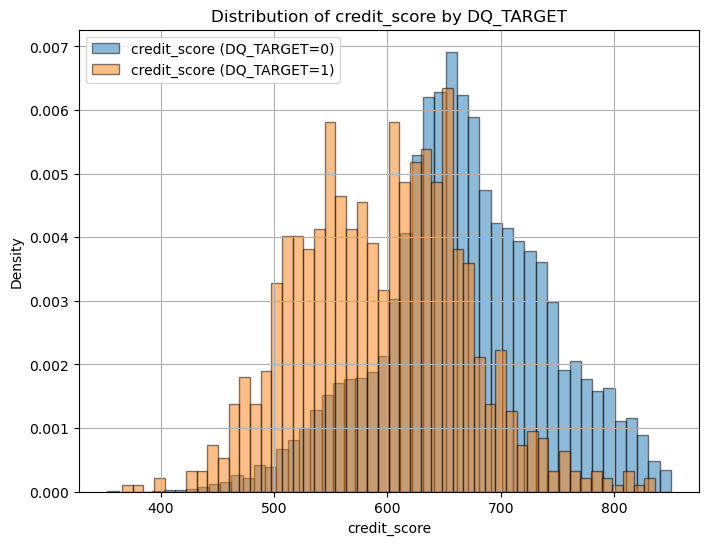

(0.3881249523054506, 1.4927461734165962e-125)

In [11]:
ks_test(consDF, ftr='credit_score', target='DQ_TARGET')

### Credit / Debit - DQ Target

In [12]:
trxnDF_prc = trxnDF.copy()
trxnDF_prc['cd_num'] = trxnDF_prc.credit_or_debit.apply(lambda x: 1 if x == 'CREDIT' else -1)
trxnDF_prc = trxnDF_prc.groupby('prism_consumer_id')['cd_num'].sum().reset_index()

trxnDF_prc.head()

,prism_consumer_id,cd_num
0,0,-332
1,1,-172
2,10,-171
3,100,-22
4,1000,-81


In [13]:
consTrxnDF = consDF.merge(trxnDF_prc, how='inner', on='prism_consumer_id',)

consTrxnDF.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,cd_num
0,0,2021-09-01,726.0000,0.0000,-332
1,1,2021-07-01,626.0000,0.0000,-172
2,2,2021-05-01,680.0000,0.0000,-286
3,3,2021-03-01,734.0000,0.0000,-169
4,4,2021-10-01,676.0000,0.0000,-226


In [14]:
corr_cd = consTrxnDF.cd_num.corr(consTrxnDF.DQ_TARGET)
corr_cd

0.034963946187154316

In [15]:
cd_X = consTrxnDF[['cd_num']]
y = consTrxnDF[['DQ_TARGET']]
accuracy, roc_auc, confusion_matrix, cr = lr_best_single(cd_X, y)

ROC AUC Score: 0.5622
Accuracy: 0.9207
r^2 value: 0.0012

Confusion Matrix:
[[2137    0]
 [ 184    0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2137
         1.0       0.00      0.00      0.00       184

    accuracy                           0.92      2321
   macro avg       0.46      0.50      0.48      2321
weighted avg       0.85      0.92      0.88      2321



/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning

KS_stat  = 0.10349583584347188
p value = 1.4126770198758131e-08
Num of bins = 50


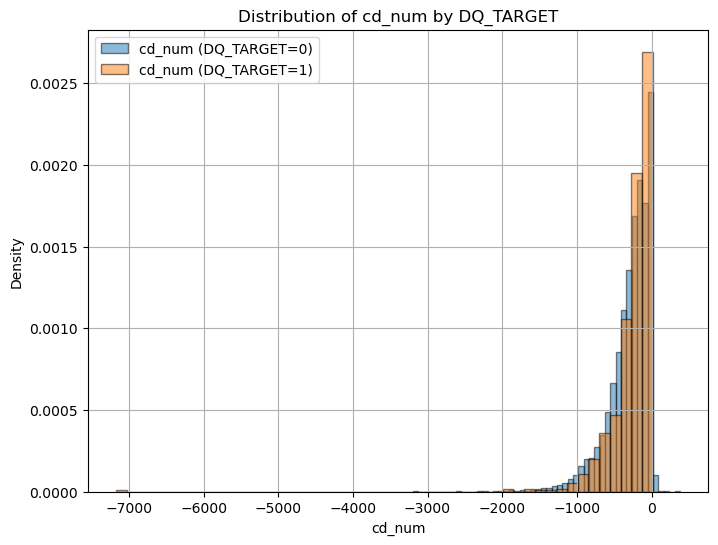

(0.10349583584347188, 1.4126770198758131e-08)

In [16]:
ks_test(consTrxnDF, ftr='cd_num', target='DQ_TARGET')

# Week 2 - Balance / Income Ftrs

### Balances over time

In [17]:
display(consDF.head()), display(acctDF)

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0000,0.0000
1,1,2021-07-01,626.0000,0.0000
2,2,2021-05-01,680.0000,0.0000
3,3,2021-03-01,734.0000,0.0000
4,4,2021-10-01,676.0000,0.0000


,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.7500
24462,11615,24462,SAVINGS,2022-03-30,5.0000
24463,11615,24463,CHECKING,2022-03-30,"1,956.4600"
24464,12210,24464,CHECKING,2022-03-28,"2,701.5100"


(None, None)

In [18]:
good = consDF[consDF['DQ_TARGET'] == 0].sample(n=3).prism_consumer_id.values
bad = consDF[consDF['DQ_TARGET'] == 1].sample(n=3).prism_consumer_id.values

good, bad

(array(['2095', '12799', '2254'], dtype=object),
 array(['5354', '2162', '7146'], dtype=object))

In [19]:
def plot_good_bad(ids=None):
    if not ids:
        good = consDF[consDF['DQ_TARGET'] == 0].sample(n=3).prism_consumer_id.values
        bad = consDF[consDF['DQ_TARGET'] == 1].sample(n=3).prism_consumer_id.values
    else:
        good = ids[:len(ids)//2]
        bad = ids[len(ids)//2:]

    good_colors = cm.Greens([0.4, 0.6, 0.8])  # Three shades of green
    bad_colors = cm.Reds([0.4, 0.6, 0.8])     # Three shades of red


    for i, cid in enumerate(good):
        data = acctDF[acctDF['prism_consumer_id'] == cid]
        plt.plot(
            data['balance_date'], 
            data['balance'], 
            marker='o', 
            label=f'Good Consumer {cid}',
            color=good_colors[i % len(good_colors)]  # Cycle through green shades
        )
    
    # Plot bad consumers
    for i, cid in enumerate(bad):
        data = acctDF[acctDF['prism_consumer_id'] == cid]
        plt.plot(
            data['balance_date'], 
            data['balance'], 
            marker='o', 
            label=f'Bad Consumer {cid}',
            color=bad_colors[i % len(bad_colors)]  # Cycle through red shades
        )


    plt.title('Balance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.grid(True)
    plt.legend(title='Consumer ID')
    plt.tight_layout()
    plt.show()



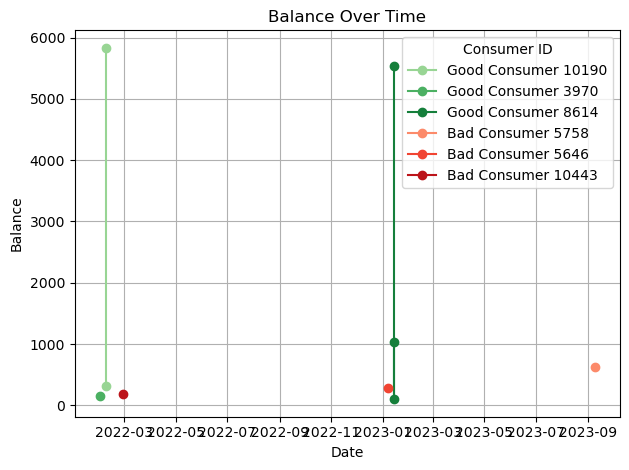

In [20]:
plot_good_bad()

In [21]:
acctDF[acctDF.prism_consumer_id == '5837']

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
16347,5837,16347,CHECKING,2023-08-06,222.3300


In [22]:
trxnDF[trxnDF.prism_consumer_id == '5837'].sort_values(by='posted_date')

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
2816935,5837,2814923,3,"1,905.3900",CREDIT,2023-05-10
2817053,5837,2815041,35,104.9900,DEBIT,2023-05-10
2817052,5837,2815040,35,44.2500,DEBIT,2023-05-10
2817051,5837,2815039,35,21.9300,DEBIT,2023-05-10
2817050,5837,2815038,1,18.3800,DEBIT,2023-05-10
...,...,...,...,...,...,...
2817531,5837,2815519,17,5.8600,DEBIT,2023-08-05
2817537,5837,2815525,21,15.1600,DEBIT,2023-08-06
2817538,5837,2815526,16,25.0000,DEBIT,2023-08-06
2817539,5837,2815527,14,2.9500,DEBIT,2023-08-07


In [23]:
def plot_incomes(cids=None, year=None):
    if year:
        temp = acctDF[acctDF.balance_date.dt.year == 2023]
    else:
        temp = acctDF.copy()
    if not cids:
        temp = temp.groupby('prism_consumer_id').count()
        temp = temp[temp['balance_date'] >= 5]
        cids = temp.reset_index().prism_consumer_id.sample(n=3).values

    colors = cm.tab10.colors
    plt.figure(figsize=(16, 8))

    for i, cid in enumerate(cids):
        data = acctDF[acctDF['prism_consumer_id'] == cid]
        plt.plot(
            data['balance_date'], 
            data['balance'], 
            marker='o', 
            label=f'Consumer {cid}',
            color=colors[i % len(colors)] 
        )
  
    plt.title('Balance Over Time for Multiple Consumers')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.grid(True)
    plt.legend(title='Consumer ID')
    plt.tight_layout()
    plt.show()


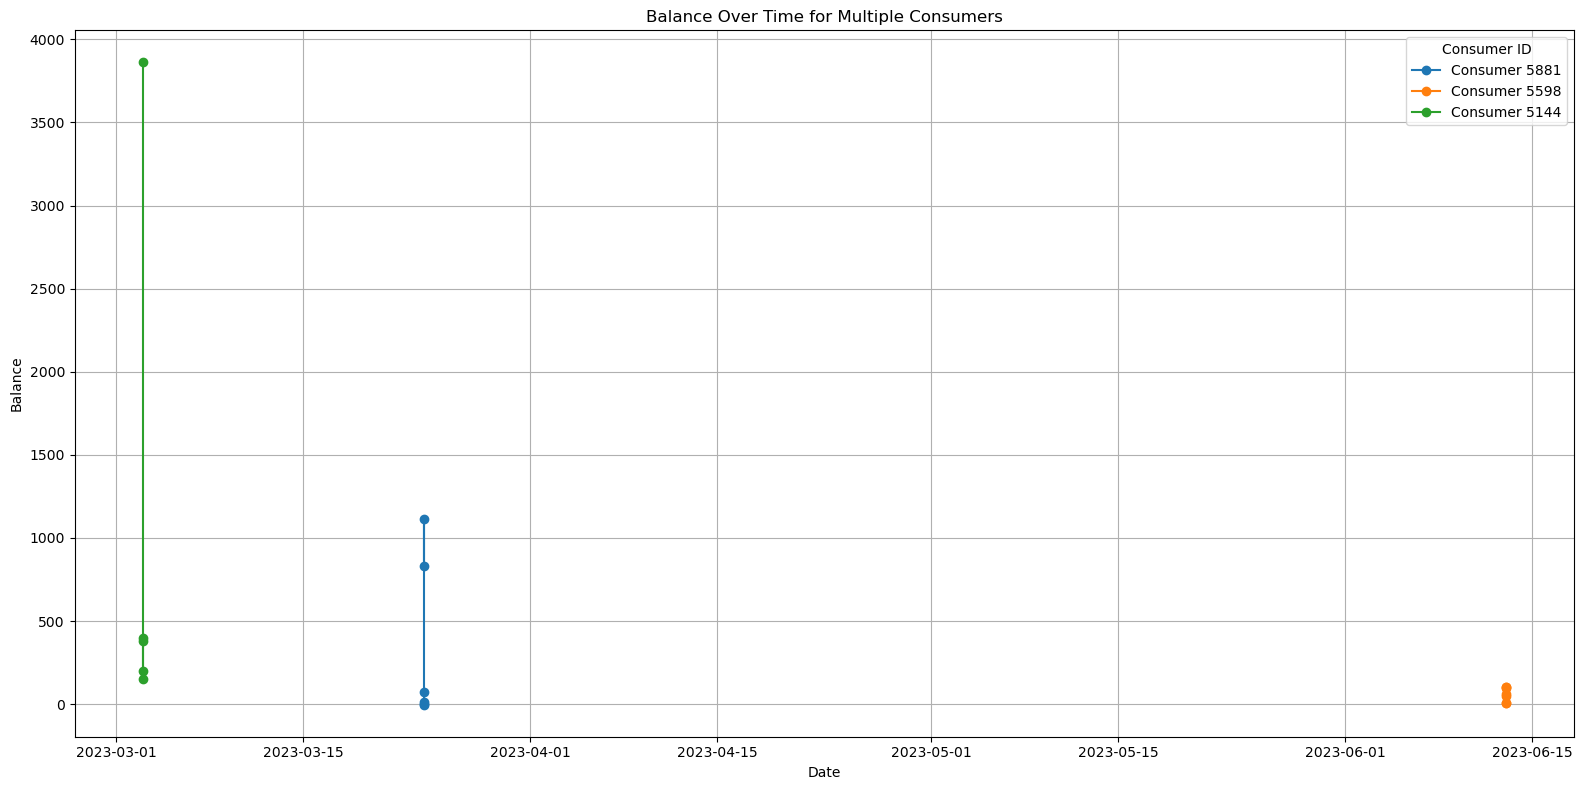

In [24]:
plot_incomes(year=2023)

In [25]:
acctDF.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"


### Running Balance 

In [26]:
x = acctDF[acctDF.account_type == 'CHECKING']
x = x[x.prism_consumer_id == '7855']

x

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
16566,7855,16566,CHECKING,2023-11-07,"5,588.5800"
16568,7855,16568,CHECKING,2023-11-07,"1,324.3100"
16569,7855,16569,CHECKING,2023-11-07,0.4000
16570,7855,16570,CHECKING,2023-11-07,499.6400


In [27]:
check_acct_totals = acctDF[acctDF.account_type == 'CHECKING'].groupby(['prism_consumer_id', 'balance_date']).sum()
check_acct_totals = check_acct_totals.reset_index()
check_acct_totals = check_acct_totals.drop(axis=1,labels='prism_account_id')
check_acct_totals.head()

,prism_consumer_id,balance_date,account_type,balance
0,0,2021-08-31,CHECKING,294.6700
1,1,2021-06-30,CHECKING,91.2400
2,10,2022-01-31,CHECKING,822.7500
3,100,2021-04-30,CHECKING,802.4000
4,1000,2023-01-31,CHECKING,95.2300


In [28]:
balanceDF = trxnDF.copy()
balanceDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16


In [29]:
t1 = check_acct_totals[check_acct_totals.prism_consumer_id == '3023']
t1

,prism_consumer_id,balance_date,account_type,balance
5395,3023,2021-08-31,CHECKING,225.9500


In [30]:
t2 = balanceDF[balanceDF.prism_consumer_id == '3023']
t2

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16
...,...,...,...,...,...,...
200,3023,200,39,10.9100,DEBIT,2021-09-17
201,3023,201,4,81.7300,DEBIT,2021-09-18
202,3023,202,16,21.8500,DEBIT,2021-09-20
203,3023,203,45,25.0000,DEBIT,2021-09-20


In [31]:
tbd = t1.balance_date.values[0]
orig_balance = t1.balance.values[0]
curr_balance = orig_balance
pre_balances = [orig_balance]
post_balances = []

print(tbd, curr_balance)
t3 = t2[t2.posted_date <= tbd].sort_values(by='posted_date', ascending=False)
t5 = t2[t2.posted_date > tbd].sort_values(by='posted_date', ascending=True)
t3

2021-08-31T00:00:00.000000000 225.95


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
186,3023,186,45,40.0000,DEBIT,2021-08-31
185,3023,185,45,25.0000,DEBIT,2021-08-30
184,3023,184,45,25.0000,DEBIT,2021-08-30
183,3023,183,45,25.0000,DEBIT,2021-08-30
182,3023,182,45,25.0000,DEBIT,2021-08-30
...,...,...,...,...,...,...
48,3023,48,45,40.0000,DEBIT,2021-03-30
47,3023,47,45,25.0000,DEBIT,2021-03-29
8,3023,8,1,340.0000,CREDIT,2021-03-27
7,3023,7,1,240.0000,CREDIT,2021-03-27


In [32]:
for i, row in t3.iterrows(): #t3.iloc[1:].iterrows()
    if row.credit_or_debit == 'CREDIT':
        curr_balance -= row.amount
    else:
        curr_balance += row.amount
    pre_balances.append(curr_balance)

curr_balance = orig_balance
for i, row in t5.iterrows():
    if row.credit_or_debit == 'CREDIT':
        curr_balance += row.amount
    else:
        curr_balance -= row.amount
    post_balances.append(curr_balance)

In [33]:
t4 = t3.copy()

t4['curr_balance'] = pre_balances[:-1]
t4.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
186,3023,186,45,40.0000,DEBIT,2021-08-31,225.9500
185,3023,185,45,25.0000,DEBIT,2021-08-30,265.9500
184,3023,184,45,25.0000,DEBIT,2021-08-30,290.9500
183,3023,183,45,25.0000,DEBIT,2021-08-30,315.9500
182,3023,182,45,25.0000,DEBIT,2021-08-30,340.9500


In [34]:
t6 = t5.copy()

t6['curr_balance'] = post_balances
t6.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
187,3023,187,45,50.0000,DEBIT,2021-09-02,175.9500
37,3023,37,2,500.0000,CREDIT,2021-09-03,675.9500
38,3023,38,4,0.0900,CREDIT,2021-09-03,676.0400
188,3023,188,45,60.0000,DEBIT,2021-09-03,616.0400
189,3023,189,45,100.0000,DEBIT,2021-09-03,516.0400


In [35]:
pd.concat([t4, t6], axis=0)

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
186,3023,186,45,40.0000,DEBIT,2021-08-31,225.9500
185,3023,185,45,25.0000,DEBIT,2021-08-30,265.9500
184,3023,184,45,25.0000,DEBIT,2021-08-30,290.9500
183,3023,183,45,25.0000,DEBIT,2021-08-30,315.9500
182,3023,182,45,25.0000,DEBIT,2021-08-30,340.9500
...,...,...,...,...,...,...,...
201,3023,201,4,81.7300,DEBIT,2021-09-18,"1,027.6500"
40,3023,40,6,81.7300,CREDIT,2021-09-19,"1,109.3800"
202,3023,202,16,21.8500,DEBIT,2021-09-20,"1,087.5300"
203,3023,203,45,25.0000,DEBIT,2021-09-20,"1,062.5300"


In [84]:
def calc_balances(cids, check_acct_totals, balanceDF):
    # takes too long -- will have to do for one consumer (or a couple consumers) at a time
    to_concat = []

    for cid in cids:    
        t1 = check_acct_totals[check_acct_totals.prism_consumer_id == cid]
        t2 = balanceDF[balanceDF.prism_consumer_id == cid]

        tbd = t1.balance_date.values[0]
        orig_balance = t1.balance.values[0]
        curr_balance = orig_balance
        pre_balances = [orig_balance]
        post_balances = []
        
        preDF = t2[t2.posted_date <= tbd].sort_values(by='posted_date', ascending=False)
        postDF = t2[t2.posted_date > tbd].sort_values(by='posted_date', ascending=True)

        for i, row in preDF.iterrows():
            if row.credit_or_debit == 'CREDIT':
                curr_balance -= row.amount
            else:
                curr_balance += row.amount
            pre_balances.append(curr_balance)
        
        curr_balance = orig_balance
        for i, row in postDF.iterrows():
            if row.credit_or_debit == 'CREDIT':
                curr_balance += row.amount
            else:
                curr_balance -= row.amount
            post_balances.append(curr_balance)
            
        preDF['curr_balance'] = pre_balances[:-1]
        postDF['curr_balance'] = post_balances

        to_concat.append(pd.concat([preDF, postDF], axis=0))

    return pd.concat(to_concat, axis=0)

In [37]:
good = consDF[(consDF['DQ_TARGET'] == 0) & (consDF['prism_consumer_id'].isin(check_acct_totals['prism_consumer_id']))].sample(n=3).prism_consumer_id.values
bad = consDF[(consDF['DQ_TARGET'] == 0) & (consDF['prism_consumer_id'].isin(check_acct_totals['prism_consumer_id']))].sample(n=3).prism_consumer_id.values

ids = np.concatenate((good,bad))

In [38]:
ids

array(['2086', '936', '3946', '6066', '13028', '6423'], dtype=object)

In [39]:
balances_sub = calc_balances(ids, check_acct_totals, balanceDF)
balances_sub.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
316459,2086,316266,4,0.2900,CREDIT,2021-03-19,375.1700
316442,2086,316249,4,0.0100,CREDIT,2021-03-19,374.8800
316458,2086,316265,4,0.1900,CREDIT,2021-02-19,374.8700
316441,2086,316248,4,0.0100,CREDIT,2021-02-19,374.6800
316457,2086,316264,2,300.0000,CREDIT,2021-02-18,374.6700


In [40]:
def plot_balance(good, bad, data):
    good_colors = cm.Greens([0.4, 0.6, 0.8])  # Three shades of green
    bad_colors = cm.Reds([0.4, 0.6, 0.8])     # Three shades of red
    plt.figure(figsize=(16, 8))

    for i, cid in enumerate(good):
        data_sub = data[data['prism_consumer_id'] == cid]
        plt.plot(
            data_sub['posted_date'], 
            data_sub['curr_balance'], 
            marker='o', 
            label=f'Good Consumer {cid}',
            color=good_colors[i % len(good_colors)]  # Cycle through green shades
        )
    
    # Plot bad consumers
    for i, cid in enumerate(bad):
        data_sub = data[data['prism_consumer_id'] == cid]
        plt.plot(
            data_sub['posted_date'], 
            data_sub['curr_balance'], 
            marker='o', 
            label=f'Bad Consumer {cid}',
            color=bad_colors[i % len(bad_colors)]  # Cycle through red shades
        )


    plt.title('Balance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.grid(True)
    plt.legend(title='Consumer ID')
    plt.tight_layout()
    plt.show()

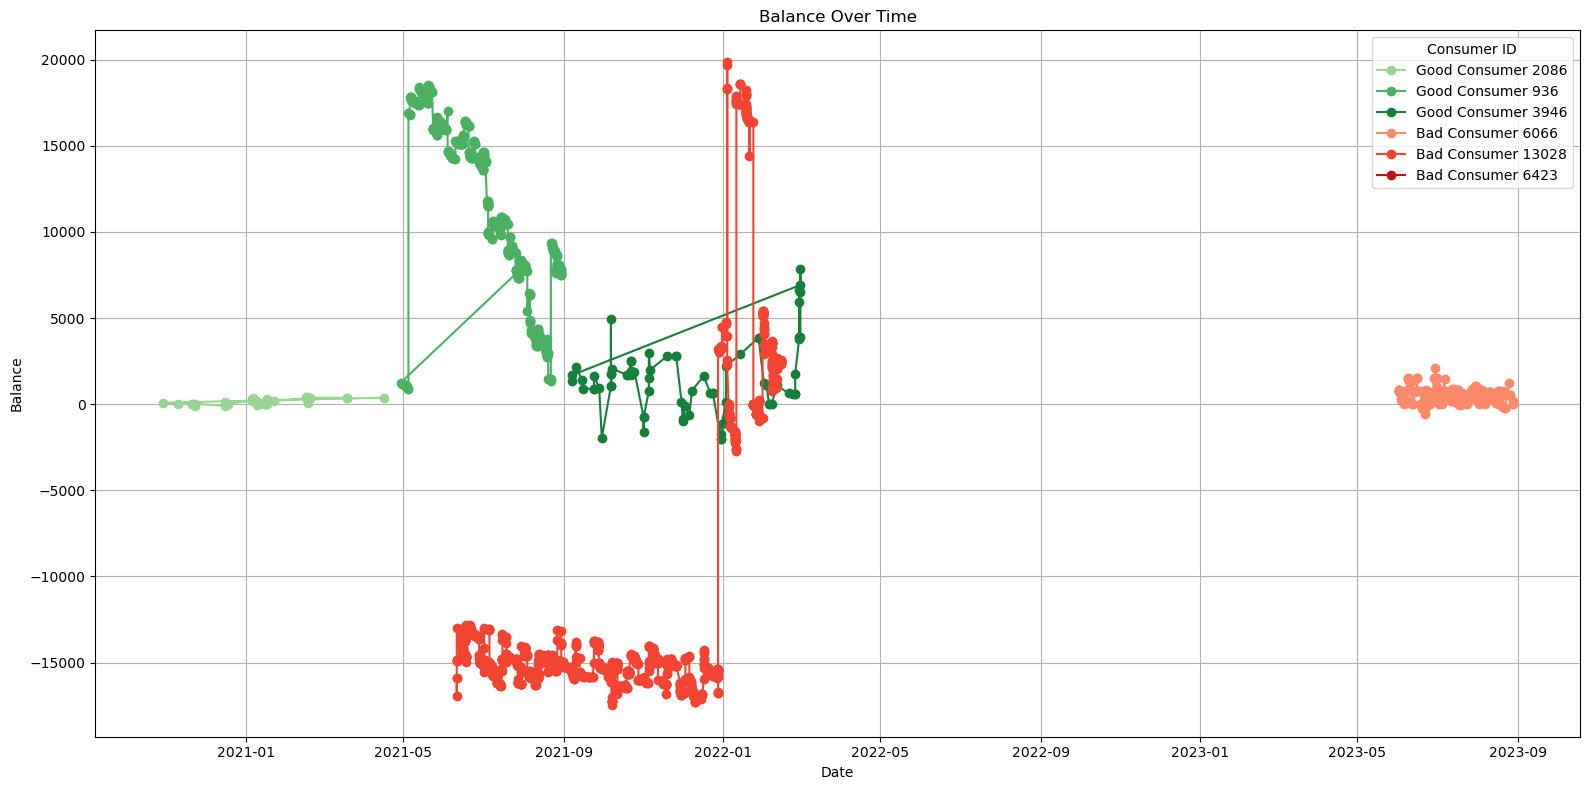

In [41]:
plot_balance(good, bad, balances_sub)

## Calculating Running Balance for All Consumers

In [42]:
def calc_balances_all(check_acct_totals, balanceDF):
    # Merge transactions with account balances
    merged = balanceDF.merge(
        check_acct_totals[['prism_consumer_id', 'balance_date', 'balance']], 
        on='prism_consumer_id', how='left'
    )

    # Identify pre and post transactions
    merged['is_pre'] = merged['posted_date'] <= merged['balance_date']

    # Set adjustment values based on pre/post period
    merged['adjustment'] = 0.0
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = -merged['amount']
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = -merged['amount']

    # Pre-balance transactions: Sort descending and apply reverse cumsum
    pre_trans = merged[merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, False])
    pre_trans['curr_balance'] = pre_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + pre_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Post-balance transactions: Sort ascending and apply forward cumsum
    post_trans = merged[~merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, True])
    post_trans['curr_balance'] = post_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + post_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Combine results
    result = pd.concat([pre_trans, post_trans]).sort_values(by=['prism_consumer_id', 'posted_date'])

    return result[['prism_consumer_id', 'prism_transaction_id', 'category', 'amount', 'credit_or_debit', 'posted_date', 'curr_balance']].sort_values(by='posted_date', ascending=False)



In [43]:
balanceDF_all = calc_balances_all(check_acct_totals, balanceDF)
balanceDF_all.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
2518565,8144,2486689,3,95.1300,CREDIT,2024-05-06,-66.3800
2518585,8144,2486709,17,4.0400,DEBIT,2024-05-06,87.6600
2518578,8144,2486702,1,150.0000,DEBIT,2024-05-06,83.6200
2518582,8144,2486706,17,12.3200,DEBIT,2024-05-03,117.7600
2518568,8144,2486692,19,83.0000,DEBIT,2024-05-03,105.4400


In [44]:
def calculate_curr_balance(row, prev):
    print(row.amount, type(row.amount))
    print(prev, type(prev))
    if row.posted_date <= row.balance_date:
        if row.credit_or_debit == 'credit':
            return prev - row.amount
        else:
            return prev + row.amount
    else:
        if row.credit_or_debit == 'credit':
            return prev + row.amount
        else:
            return prev - row.amount

# Week 3 - Feature Generation (100)

In [45]:
def last_6_months(group):
    latest_date = group['posted_date'].max()  # Find latest date for the consumer
    cutoff_date = latest_date - pd.DateOffset(months=6)  # Compute cutoff date
    return group[group['posted_date'] >= cutoff_date]  # Filter transactions

In [46]:
def filter_time_window(df, days=None, months=None, years=None):
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

#### - Mean, Median, StDev, Range of following features
     - current_balance (generated)
     - transaction `amount`

- Count of each inflow category (Paycheck, deposit, external transfer, investment income, benefits)
     - StDev of paychecks (maybe other metrics, maybe other categories)
       

- Differentiate between `mortgage` and `rent`
- Time period (over 1 month, 6 months, year)
     - outflows (check by category potentially)
     - inflows (check by category -- paycheck specifically)


- 

In [47]:
display(trxnDF.head()), display(acctDF.head()), display(consDF.head())

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16


,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0000,0.0000
1,1,2021-07-01,626.0000,0.0000
2,2,2021-05-01,680.0000,0.0000
3,3,2021-03-01,734.0000,0.0000
4,4,2021-10-01,676.0000,0.0000


(None, None, None)

In [48]:
trxnUpd = trxnDF.copy()
trxnUpd.loc[trxnUpd['credit_or_debit'] == 'DEBIT', 'amount'] *= -1

sample = trxnUpd[trxnUpd.prism_consumer_id == '1']

sample

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
1236184,1,1234671,0,200.0000,CREDIT,2021-01-15
1236185,1,1234672,0,200.0000,CREDIT,2021-01-29
1236186,1,1234673,0,200.0000,CREDIT,2021-02-12
1236187,1,1234674,4,0.4500,CREDIT,2021-02-12
1236188,1,1234675,0,200.0000,CREDIT,2021-02-26
...,...,...,...,...,...,...
1236493,1,1234980,20,-10.8900,DEBIT,2021-07-08
1236494,1,1234981,14,-58.9500,DEBIT,2021-07-12
1236495,1,1234982,35,-16.8700,DEBIT,2021-07-13
1236496,1,1234983,27,-14.2000,DEBIT,2021-07-14


### Amount Features

In [49]:
amnt_ftrs = trxnUpd.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max',])
amnt_ftrs.columns = ['amount_' + x for x in amnt_ftrs.columns]

In [50]:
amnt_ftrs.head()

,amount_mean,amount_std,amount_median,amount_min,amount_max
prism_consumer_id,,,,,
0,-1.2784,203.8645,-19.2650,-500.0000,"1,400.0000"
1,5.7498,301.4489,-19.3950,"-1,390.8500","1,400.0000"
10,-3.4899,257.6357,-27.8800,-625.0000,"1,463.4500"
100,-36.9325,846.2432,-150.0000,"-2,800.0000","2,780.0000"
1000,2.0762,"1,669.6934",-200.0000,"-10,000.0000","10,614.3700"


### Balance Features

In [51]:
balance_ftrs = balanceDF_all.groupby('prism_consumer_id')['curr_balance'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_ftrs.columns = ['balance_' + x for x in balance_ftrs.columns]
balance_ftrs.head()

,balance_mean,balance_std,balance_median,balance_min,balance_max
prism_consumer_id,,,,,
0,"1,256.6848",964.2451,"1,058.6300",-116.7300,"3,787.7300"
1,"-1,217.0604","1,217.9688","-1,124.9200","-3,573.7800","1,204.6600"
10,981.5100,513.1332,996.1900,-95.9400,"2,039.3300"
100,"-2,946.2203","1,907.6051","-3,326.6450","-6,273.1800","1,130.5100"
1000,497.5453,"1,499.9720",404.9500,"-7,369.4000","12,630.6000"


In [52]:
# balance_recent = balanceDF_all.groupby('prism_consumer_id', group_keys=False,).apply(last_6_months)
# balance_recent.head()

In [53]:
# balance_recent_metrics = balance_recent.groupby('prism_consumer_id')['curr_balance'].agg(['mean', 'std', 'median', 'min', 'max'])
# balance_recent_metrics.columns = ['balance_last_6_' + x for x in balance_recent_metrics.columns]
# balance_ftrs = pd.concat([balance_ftrs, balance_recent_metrics], axis=1)
# balance_ftrs.head()

In [54]:
# balance_ftrs.iloc[10:20]

In [55]:
# balance deltas - overall, 14 days, 30 days, 3 months, 6 months, 1 year

In [56]:
balance_last_14_days = filter_time_window(balanceDF_all, days=14)
balance_last_30_days = filter_time_window(balanceDF_all, days=30)
balance_last_3_months = filter_time_window(balanceDF_all, months=1)
balance_last_6_months = filter_time_window(balanceDF_all, months=6)
balance_last_year = filter_time_window(balanceDF_all, years=1)


/tmp/ipykernel_330/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/4222159680.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on t

In [57]:
balance_last_14_days_metrics = balance_last_14_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_14_days_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_14_days_metrics.columns]

balance_last_30_days_metrics = balance_last_30_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_30_days_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_30_days_metrics.columns]

balance_last_3_months_metrics = balance_last_3_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_3_months_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_3_months_metrics.columns]

balance_last_6_months_metrics = balance_last_6_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_6_months_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_6_months_metrics.columns]

balance_last_year_metrics = balance_last_year.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_year_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_year_metrics.columns]




balance_ftrs = pd.concat([balance_ftrs, balance_last_14_days_metrics, balance_last_30_days_metrics, balance_last_3_months_metrics, balance_last_6_months_metrics, balance_last_year_metrics], axis=1)

print(balance_ftrs.shape[1])

balance_ftrs.head()

30


,balance_mean,balance_std,balance_median,balance_min,balance_max,balance_last_14_days_mean,balance_last_14_days_std,balance_last_14_days_median,balance_last_14_days_min,balance_last_14_days_max,...,balance_last_14_days_mean,balance_last_14_days_std,balance_last_14_days_median,balance_last_14_days_min,balance_last_14_days_max,balance_last_14_days_mean,balance_last_14_days_std,balance_last_14_days_median,balance_last_14_days_min,balance_last_14_days_max
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,"1,256.6848",964.2451,"1,058.6300",-116.7300,"3,787.7300",94.2562,221.2070,20.0000,2.1900,"1,250.3000",...,71.8020,190.7726,20.0250,0.0000,"1,400.0000",71.8020,190.7726,20.0250,0.0000,"1,400.0000"
1,"-1,217.0604","1,217.9688","-1,124.9200","-3,573.7800","1,204.6600",156.3676,259.5497,68.8000,0.0700,958.4700,...,152.8732,259.7302,40.0000,0.0700,"1,400.0000",152.8732,259.7302,40.0000,0.0700,"1,400.0000"
10,981.5100,513.1332,996.1900,-95.9400,"2,039.3300",188.8212,291.1071,68.0150,1.0000,"1,314.9400",...,124.1735,225.6633,46.8100,0.0000,"1,463.4500",124.1735,225.6633,46.8100,0.0000,"1,463.4500"
100,"-2,946.2203","1,907.6051","-3,326.6450","-6,273.1800","1,130.5100",773.0750,659.9218,844.6550,1.3600,"1,714.2500",...,614.5857,580.2290,500.0000,0.6800,"2,800.0000",614.5857,580.2290,500.0000,0.6800,"2,800.0000"
1000,497.5453,"1,499.9720",404.9500,"-7,369.4000","12,630.6000",425.4947,509.9408,260.4000,5.2200,"1,741.2800",...,740.6069,"1,495.5835",300.0000,0.0200,"10,614.3700",740.6069,"1,495.5835",300.0000,0.0200,"10,614.3700"


In [58]:
# cat_map

### Category Features

In [59]:
cat_dict = cat_map.set_index('category_id')['category'].to_dict()

In [60]:
balanceDF_all['cat_name'] = balanceDF_all.category.apply(lambda x: cat_dict[x])

balanceDF_all.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance,cat_name
2518565,8144,2486689,3,95.1300,CREDIT,2024-05-06,-66.3800,PAYCHECK
2518585,8144,2486709,17,4.0400,DEBIT,2024-05-06,87.6600,AUTOMOTIVE
2518578,8144,2486702,1,150.0000,DEBIT,2024-05-06,83.6200,EXTERNAL_TRANSFER
2518582,8144,2486706,17,12.3200,DEBIT,2024-05-03,117.7600,AUTOMOTIVE
2518568,8144,2486692,19,83.0000,DEBIT,2024-05-03,105.4400,ATM_CASH


#### Paycheck Ftrs

In [61]:
paychecks = balanceDF_all[balanceDF_all.cat_name == 'PAYCHECK']

paycheck_ftrs = paychecks.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'count'])
paycheck_ftrs.columns = ['paycheck_' + x for x in paycheck_ftrs.columns]
paycheck_ftrs.head()

,paycheck_mean,paycheck_std,paycheck_median,paycheck_min,paycheck_max,paycheck_count
prism_consumer_id,,,,,,
0,980.0622,308.4358,"1,075.3100",185.7000,"1,250.3000",9
1,851.3314,246.6009,900.0700,50.0000,"1,031.0800",14
10,981.3827,324.3054,974.4200,345.3700,"1,463.4500",15
100,"1,061.3817",427.3619,897.1000,682.9200,"1,998.0800",23
1000,"1,679.1769",238.8166,"1,733.4350",909.6500,"2,158.9300",26


In [62]:
# Apply the function to each consumer_id
paychecks_recent = paychecks.groupby('prism_consumer_id', group_keys=False,).apply(last_6_months)
paychecks_recent.head()

paychecks_recent_metrics = paychecks_recent.groupby('prism_consumer_id')['amount'].agg(['mean', 'std'])
paychecks_recent_metrics.columns = ['paycheck_last_6_' + x for x in paychecks_recent_metrics.columns] 

paycheck_ftrs = pd.concat([paycheck_ftrs, paychecks_recent_metrics,], axis=1)

/tmp/ipykernel_330/53469803.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paychecks_recent = paychecks.groupby('prism_consumer_id', group_keys=False,).apply(last_6_months)


In [63]:
paycheck_ftrs.head()

,paycheck_mean,paycheck_std,paycheck_median,paycheck_min,paycheck_max,paycheck_count,paycheck_last_6_mean,paycheck_last_6_std
prism_consumer_id,,,,,,,,
0,980.0622,308.4358,"1,075.3100",185.7000,"1,250.3000",9,980.0622,308.4358
1,851.3314,246.6009,900.0700,50.0000,"1,031.0800",14,851.3314,246.6009
10,981.3827,324.3054,974.4200,345.3700,"1,463.4500",15,981.3827,324.3054
100,"1,061.3817",427.3619,897.1000,682.9200,"1,998.0800",23,"1,061.3817",427.3619
1000,"1,679.1769",238.8166,"1,733.4350",909.6500,"2,158.9300",26,"1,679.1769",238.8166


In [64]:
paycheck_ftrs.iloc[20:30]

,paycheck_mean,paycheck_std,paycheck_median,paycheck_min,paycheck_max,paycheck_count,paycheck_last_6_mean,paycheck_last_6_std
prism_consumer_id,,,,,,,,
10017,158.4141,114.9005,143.2550,4.3600,300.0000,22,130.9688,111.2123
10018,579.2786,312.6611,690.7500,16.9200,912.9500,7,579.2786,312.6611
10019,70.3189,40.4513,57.9600,23.9700,173.5800,66,72.9615,41.6304
1002,"2,996.7864",885.2035,"3,266.9800",5.0000,"3,600.7800",14,"2,996.7864",885.2035
10020,"1,080.1023",217.4532,"1,119.2700",387.1700,"1,266.6000",13,"1,137.8467",65.5483
10021,594.4400,392.4750,636.6100,8.9500,991.5100,7,594.4400,392.4750
10022,886.8400,633.3650,"1,000.0000",1.0400,"1,896.2100",19,849.0571,643.1538
10023,371.7212,272.8031,383.2300,26.2600,"1,175.1900",25,371.7212,272.8031
10024,"2,083.1429",580.5212,"1,877.5600","1,002.6400","3,013.5100",17,"2,187.7586",557.5354


## Feature Gen (up to date)

In [65]:
# balance_ftrs.head()


In [66]:
trxcat_mappings = dict(zip(cat_map['category_id'], cat_map['category']))
nDF['category_id'] = trxnDF.category
trxnDF.category = trxnDF.category.replace(cat_mappings)

In [67]:
def filter_time_window(df, days=None, months=None, years=None):
    """
    Filters transactions for each consumer over some time period
    Args:
        df (pd.DataFrame): dataframe to window over 
        days (int): number of days to go back
        months (int): number of months to go back
        years (int): number of years to go back
    Returns:
        pd.DataFrame: windowed dataframe
    """
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [68]:
def compute_balance_delta(balanceDF_all, balance_filtered, label):
    # Get last balance per consumer
    last_balance = balanceDF_all.groupby('prism_consumer_id')['curr_balance'].last().reset_index()
    last_balance = last_balance.rename(columns={'curr_balance': 'curr_balance_last'})
    
    # Get earliest balance in the filtered dataset
    first_balance = balance_filtered.groupby('prism_consumer_id')['curr_balance'].first().reset_index()
    first_balance = first_balance.rename(columns={'curr_balance': f'curr_balance_{label}'})
    
    # Merge and compute balance delta
    df_merged = last_balance.merge(first_balance, on='prism_consumer_id', how='left')
    df_merged[f'balance_delta_{label}'] = df_merged['curr_balance_last'] - df_merged[f'curr_balance_{label}']
    
    # Keep only relevant columns
    return df_merged[['prism_consumer_id', f'balance_delta_{label}']]


In [69]:
def generate_category_features(trxnDF, cat_map, categories):
    """
    Generates transaction-based features for each selected category over multiple time windows.
    
    Parameters:
        trxnDF (pd.DataFrame): DataFrame containing transaction data.
        cat_map (pd.DataFrame): DataFrame mapping category IDs to category names.
        categories (str or list): One or more transaction categories to filter.

    Returns:
        pd.DataFrame: Aggregated features per prism_consumer_id.
    """
    if isinstance(categories, str):
        categories = [categories]

    # trxnDF = trxnDF.merge(cat_map, left_on='category', right_on='category_id', how='left')
    # trxnDF['category'] = trxnDF['category_y']
    # trxnDF = trxnDF.drop(columns=['category_id', 'category_y'])

    trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

    time_windows = {
        'overall': None,
        'last_14_days': 14,
        'last_30_days': 30,
        'last_3_months': 90,
        'last_6_months': 180,
        'last_year': 365
    }

    features_dict = {}

    for category in categories:
        # filter transactions for the current category
        filtered_trxn = trxnDF[trxnDF['category'] == category].copy()

        # get last posted date per consumer
        last_posted_dates = filtered_trxn.groupby('prism_consumer_id')['posted_date'].max()

        for window_name, days in time_windows.items():
            if days is None:
                df_time_filtered = filtered_trxn
            else:
                # consumer-specific time filters
                df_time_filtered = filtered_trxn.merge(last_posted_dates, on='prism_consumer_id', suffixes=('', '_latest'))
                df_time_filtered = df_time_filtered[df_time_filtered['posted_date'] >= (df_time_filtered['posted_date_latest'] - pd.Timedelta(days=days))]
                df_time_filtered = df_time_filtered.drop(columns=['posted_date_latest'])

            # aggregate features
            agg_features = df_time_filtered.groupby('prism_consumer_id')['amount'].agg(
                mean='mean',
                median='median',
                std='std',
                max='max',
                min='min',
                count='count'
            )

            # total transaction count per consumer in the time window
            total_trxn_counts = trxnDF.groupby('prism_consumer_id')['amount'].count()

            # compute percentage of transactions in this category for the time window
            percentage_trxn = (agg_features['count'] / total_trxn_counts).fillna(0)
            percentage_trxn = percentage_trxn.rename(f"{category}_{window_name}_percent")

            agg_features = agg_features.rename(columns=lambda x: f"{category}_{window_name}_{x}")

            features_dict[f"{category}_{window_name}"] = pd.concat([agg_features, percentage_trxn], axis=1)


    final_features = pd.concat(features_dict.values(), axis=1).fillna(0)
    return final_features


In [70]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
outflows_agg_df = trxnDF[~trxnDF['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_agg_df.columns = ['outflows_amt_' + col for col in outflows_agg_df.columns]

In [71]:
# creating filtered window transactions dfs
trxn_df_last_14_days = filter_time_window(trxnDF, days=14)
trxn_df_last_30_days = filter_time_window(trxnDF, days=30)
trxn_df_last_3_months = filter_time_window(trxnDF, months=3)
trxn_df_last_6_months = filter_time_window(trxnDF, months=6)
trxn_df_last_year = filter_time_window(trxnDF, years=1)

/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

In [72]:
%%time

balance_ftrs = balanceDF_all.groupby('prism_consumer_id')['curr_balance'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_ftrs.columns = ['balance_' + x for x in balance_ftrs.columns]
balance_last_14_days = filter_time_window(balanceDF_all, days=14)
balance_last_30_days = filter_time_window(balanceDF_all, days=30)
balance_last_3_months = filter_time_window(balanceDF_all, months=1)
balance_last_6_months = filter_time_window(balanceDF_all, months=6)
balance_last_year = filter_time_window(balanceDF_all, years=1)

balance_last_14_days_metrics = balance_last_14_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_14_days_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_14_days_metrics.columns]

balance_last_30_days_metrics = balance_last_30_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_30_days_metrics.columns = ['balance_last_30_days_' + x for x in balance_last_30_days_metrics.columns]

balance_last_3_months_metrics = balance_last_3_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_3_months_metrics.columns = ['balance_last_3_months_' + x for x in balance_last_3_months_metrics.columns]

balance_last_6_months_metrics = balance_last_6_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_6_months_metrics.columns = ['balance_last_6_months_' + x for x in balance_last_6_months_metrics.columns]

balance_last_year_metrics = balance_last_year.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
balance_last_year_metrics.columns = ['balance_last_1_year_' + x for x in balance_last_year_metrics.columns]

balance_dfs = [balance_ftrs, balance_last_14_days_metrics, balance_last_30_days_metrics, balance_last_3_months_metrics, balance_last_6_months_metrics, balance_last_year_metrics]
balance_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id'), balance_dfs)

balance_ftrs.shape

/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

CPU times: user 1min 6s, sys: 1.75 s, total: 1min 7s
Wall time: 1min 7s


(14492, 30)

In [73]:
%%time

# balance_deltas
balance_delta_overall = compute_balance_delta(balanceDF_all, balanceDF_all, 'overall')
balance_delta_14d = compute_balance_delta(balanceDF_all, balance_last_14_days, '14d')
balance_delta_30d = compute_balance_delta(balanceDF_all, balance_last_30_days, '30d')
balance_delta_3m = compute_balance_delta(balanceDF_all, balance_last_3_months, '3m')
balance_delta_6m = compute_balance_delta(balanceDF_all, balance_last_6_months, '6m')
balance_delta_1y = compute_balance_delta(balanceDF_all, balance_last_year, '1y')


balance_deltas_dfs = [balance_delta_overall, balance_last_14_days_metrics, balance_last_30_days_metrics, balance_last_3_months_metrics, balance_last_6_months_metrics, balance_last_year_metrics]
balance_deltas_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id'), balance_deltas_dfs)

balance_deltas_ftrs.shape

CPU times: user 3.19 s, sys: 103 ms, total: 3.3 s
Wall time: 3.29 s


(14492, 27)

In [74]:
# creating windowed expenses aggregate metrics
outflows_ftrs = trxnDF[~trxnDF['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_ftrs.columns = ['outflows_amt_' + col for col in outflows_ftrs.columns]

outflows_last_14_days_agg_df = trxn_df_last_14_days[~trxn_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_14_days_agg_df.columns = ['outflows_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = trxn_df_last_30_days[~trxn_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_30_days_agg_df.columns = ['outflows_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = trxn_df_last_3_months[~trxn_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_3_months_agg_df.columns = ['outflows_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = trxn_df_last_6_months[~trxn_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_6_months_agg_df.columns = ['outflows_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = trxn_df_last_year[~trxn_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_year_agg_df.columns = ['outflows_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

outflows_df = [outflows_ftrs, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df, outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df]
outflows_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id'), outflows_df)

outflows_ftrs.shape

(14400, 30)

In [75]:
cat_map.category.unique()

cat_ok = ['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'DEPOSIT', 'PAYCHECK',
       'MISCELLANEOUS', 'PAYCHECK_PLACEHOLDER', 'REFUND',
       'INVESTMENT_INCOME', 'OTHER_BENEFITS', 
       'SMALL_DOLLAR_ADVANCE', 'TAX', 'LOAN', 'INSURANCE',
       'FOOD_AND_BEVERAGES', 'UNCATEGORIZED', 'GENERAL_MERCHANDISE',
       'AUTOMOTIVE', 'GROCERIES', 'ATM_CASH', 'ENTERTAINMENT', 'TRAVEL',
       'ESSENTIAL_SERVICES', 'ACCOUNT_FEES', 'HOME_IMPROVEMENT',
       'OVERDRAFT', 'CREDIT_CARD_PAYMENT', 'HEALTHCARE_MEDICAL', 'PETS',
       'EDUCATION', 'GIFTS_DONATIONS', 'BILLS_UTILITIES', 'MORTGAGE',
       'RENT', 'BNPL', 'AUTO_LOAN',
       'BANKING_CATCH_ALL', 'DEBT', 'FITNESS', 'TRANSPORATION', 'LEGAL',
       'GOVERNMENT_SERVICES', 'RISK_CATCH_ALL', 'RTO_LTO', 'INVESTMENT',
       'GAMBLING', 'CORPORATE_PAYMENTS', 'TIME_OR_STUFF', 'PENSION']

In [76]:
%%time

category_features = generate_category_features(trxnDF, cat_map, cat_ok)
category_features.shape

CPU times: user 1min 55s, sys: 4.79 s, total: 2min
Wall time: 2min


(14492, 2016)

In [77]:
def compute_threshold_stats(df, thresholds, cat_label):
    # Count total gambling transactions
    counts = df.groupby('prism_consumer_id').size().reset_index(name=f'{cat_label}_count')

    # Check thresholds
    threshold_flags = df.groupby('prism_consumer_id')['amount'].agg(lambda x: [any(x >= t) for t in thresholds]).apply(pd.Series)
    threshold_flags.columns = [f'{cat_label}_over_{t}' for t in thresholds]
    threshold_flags = threshold_flags.astype(bool)  # Convert to True/False

    # Merge counts and flags
    result = counts.merge(threshold_flags, on='prism_consumer_id', how='left')

    return result


In [78]:
%%time

gambling_df_all = balanceDF_all[balanceDF_all['cat_name'] == 'GAMBLING']
gambling_thresholds = [50, 100, 500, 1000]

# Filter for different time periods
gambling_last_month = filter_time_window(gambling_df_all, months=1)
gambling_last_6m = filter_time_window(gambling_df_all, months=6)
gambling_last_year = filter_time_window(gambling_df_all, years=1)

gambling_stats_all = compute_threshold_stats(gambling_df_all, gambling_thresholds, 'all')
gambling_stats_month = compute_threshold_stats(gambling_last_month, gambling_thresholds, '1m')
gambling_stats_6m = compute_threshold_stats(gambling_last_6m, gambling_thresholds, '6m')
gambling_stats_year = compute_threshold_stats(gambling_last_year, gambling_thresholds, '1y')

gambling_df = [gambling_stats_all, gambling_stats_month, gambling_stats_6m, gambling_stats_year]
gambling_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id'), gambling_df)

/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_330/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

CPU times: user 5.72 s, sys: 40.2 ms, total: 5.76 s
Wall time: 5.75 s


In [79]:
feature_dfs = [balance_ftrs, category_features, outflows_ftrs, gambling_ftrs,]
features_all = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id'), feature_dfs)

features_all.shape

(1537, 2097)

In [80]:
balanceDF_all.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance,cat_name
2518565,8144,2486689,3,95.1300,CREDIT,2024-05-06,-66.3800,PAYCHECK
2518585,8144,2486709,17,4.0400,DEBIT,2024-05-06,87.6600,AUTOMOTIVE
2518578,8144,2486702,1,150.0000,DEBIT,2024-05-06,83.6200,EXTERNAL_TRANSFER
2518582,8144,2486706,17,12.3200,DEBIT,2024-05-03,117.7600,AUTOMOTIVE
2518568,8144,2486692,19,83.0000,DEBIT,2024-05-03,105.4400,ATM_CASH


In [81]:
balanceDF_updAmnts = balanceDF_all.copy()
balanceDF_updAmnts.loc[balanceDF_updAmnts['credit_or_debit'] == 'DEBIT', 'amount'] *= -1
balanceDF_updAmnts.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance,cat_name
2518565,8144,2486689,3,95.1300,CREDIT,2024-05-06,-66.3800,PAYCHECK
2518585,8144,2486709,17,-4.0400,DEBIT,2024-05-06,87.6600,AUTOMOTIVE
2518578,8144,2486702,1,-150.0000,DEBIT,2024-05-06,83.6200,EXTERNAL_TRANSFER
2518582,8144,2486706,17,-12.3200,DEBIT,2024-05-03,117.7600,AUTOMOTIVE
2518568,8144,2486692,19,-83.0000,DEBIT,2024-05-03,105.4400,ATM_CASH


In [82]:
def check_category_corr(category):
    count_col = f'{category}_count'
    amnt_col = f'{category}_amnt'
    
    ftr_counts = (
        balanceDF_all[balanceDF_all['cat_name'] == category]
        .groupby('prism_consumer_id')['cat_name']
        .count()
        .reset_index(name=count_col)
    )

    ftr_amounts = (
        balanceDF_updAmnts[balanceDF_updAmnts['cat_name'] == category]
        .groupby('prism_consumer_id')['amount']
        .sum()
        .reset_index(name=amnt_col)
    )

    # Ensure all consumers are included, filling missing counts with 0
    all_consumers = balanceDF_all[['prism_consumer_id']].drop_duplicates()
    temp_cnt = all_consumers.merge(ftr_counts, on='prism_consumer_id', how='left').fillna({count_col: 0})
    temp_amnt = all_consumers.merge(ftr_amounts, on='prism_consumer_id', how='left').fillna({amnt_col: 0})

    # Convert to int since counts should be whole numbers
    temp_cnt[count_col] = temp_cnt[count_col].astype(int)
    temp_amnt[count_col] = temp_amnt[amnt_col].astype(int) 

    result_cnt = consDF.merge(temp_cnt, how='left', on='prism_consumer_id')
    result_amnt = consDF.merge(temp_amnt, how='left', on='prism_consumer_id')
    
    ks_test(result_cnt, ftr=count_col, target='DQ_TARGET')
    ks_test(result_amnt, ftr=amnt_col, target='DQ_TARGET')


KS_stat  = 0.024158524311806095
p value = 0.6801915718988596
Num of bins = 10


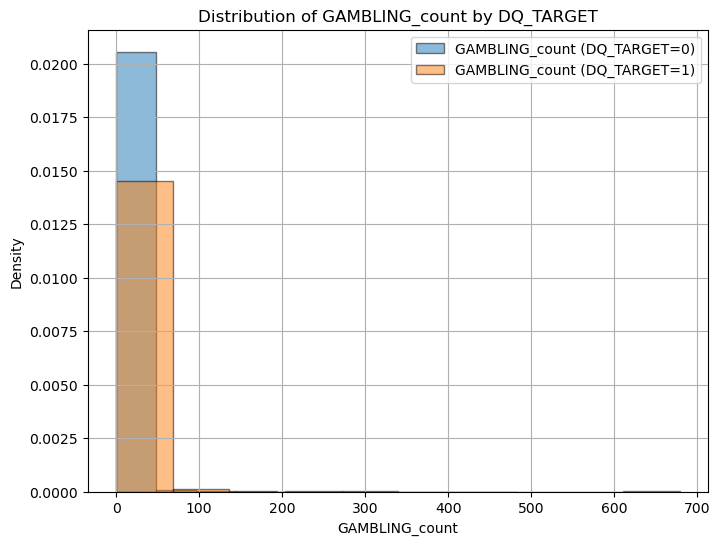

KS_stat  = 0.018578887268933572
p value = 0.918921572327408
Num of bins = 10


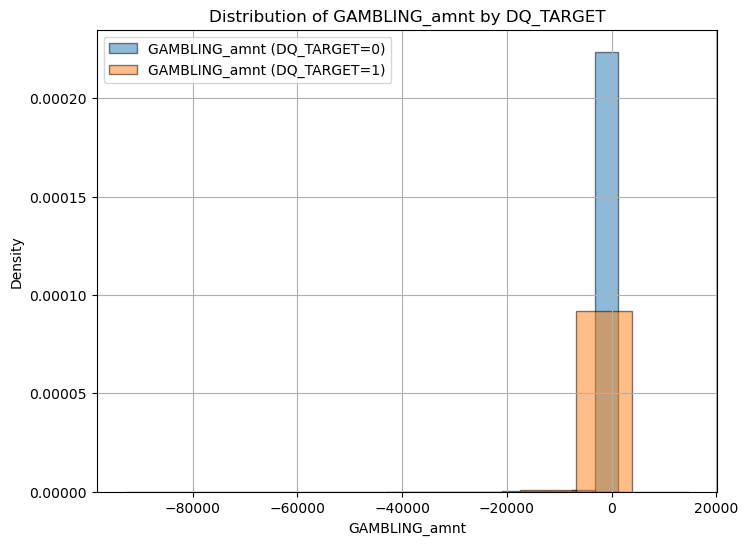

In [83]:
check_category_corr("GAMBLING")